# Supplementary Figure 9: LHHR and HHLR priors

The priors utilised in the LHHR and HHLR experiments. The opacity indicates 50%, 95%, and 99% credible intervals in order of decreasing opacity.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(janitor, lib.loc = additional_package_lib)
  library(latex2exp, lib.loc = additional_package_lib)
  library(patchwork)
  library(scico)
})

## Utility functions

In [2]:
inv_logit <- function(x){
  # The inverse logit or sigmoid function, used often in calculating probabilities
  #
  # Inputs:
  #  x  numeric, can be a vector
  #
  # Outputs:
  #  _  same shape as input, will be in (0, 1)

  1 / (1 + exp(-x))
}

yeo_johnson <- function(x, lambda) {
  # Yeo-Johnson transform of x using parameter lambda
  #
  # Inputs:
  #  x       numeric
  #          the numeric (vector) to be transformed
  #  lambda  numeric
  #          real parameter defining the transform
  # 
  # Outputs:
  #  _       numeric
  #          transformed vector same shape as x
    
  eps <- 1e-5
  if (x >= 0.0){
    if (abs(lambda) < eps){
      log1p(x)
    } else {
      (((x + 1.0) ^ lambda) - 1.0) / lambda
    }
  } else {
    if (abs(lambda - 2.0) < eps) {
      -log1p(-x)
    } else {
      -(((-x + 1.0) ^ (2.0 - lambda)) - 1.0) / (2.0 - lambda)
    }
  }
}

quantiles_for_curve_plot_with_bounds <- function(variable, par1, par2, 
                                                 probs = c(0.025, 0.25, 0.5, 0.75, 0.975)){
  # Calculating quantiles on hail and reporting probability but designed for 
  # non-vectorised usage.
  #
  # Inputs:
  #  variable  vector
  #            the vector against which we are plotting the function
  #  par1      vector
  #            draws of the location parameter of the logit function
  #  par2      vector
  #            draws of the slope parameter of the logit function
  #  probs     vector, default c(0.025, 0.25, 0.5, 0.75, 0.975)
  #            desired quantiles
  # 
  # Outputs:
  #  _         tibble
  #            columns giving the `variable' value and desired quantiles
    
  # x axis using variable
  x <- seq(min(variable), max(variable), length.out = 100)

  # preallocate matrix
  mat_func <- matrix(0, nrow = length(x), ncol = length(par1))

  # calculating probability using each pair
  for (i in 1:length(par1)) {
    mat_func[, i] <- inv_logit(par1[i] + par2[i] * x)
  }
  
  # summarise via quantile function
  apply(mat_func, MARGIN = 1, FUN = quantile, probs = probs) %>%
    t() %>%
    cbind(x = x) %>%
    as_tibble(.name_repair = make_clean_names)
}

In [3]:
generate_sim_prior_samples_and_plot <- function(prior_regime_type, var){
  # Calculating prior samples for the simulations and plotting them
  #
  # Inputs:
  #  prior_regime_type  str
  #                     the prior regime in question 
  #  var                str
  #                     variable of interest (hail or report)
  # 
  # Outputs:
  #  _                  ggplot
  #                     plot with the priors for the LHHR and HHLR regimes

  # number of simulations
  num_sim <- 4000

  # declaring sim parameters
  # naming aligns with stan files where all paramters are beta and
  # their role in the hail or reporting function is named explicity
  if (var == "hail") {
    lhhr_beta <- c(-7, 0.0932)
    hhlr_beta <- c(-8, 0.3)
  } else if (var == "report") {
    lhhr_beta  <- c(-2, 1)
    hhlr_beta <- c(-4.258, 0.5)
  }

  # prior means are encapsulated in priors
  lhhr_mean <- lhhr_beta
  hhlr_mean <- hhlr_beta

  # declaring prior variances    
  if (var == "hail") {
    var_all <- c(1/6, 1/30)
    var_mult <- 3
  } else if (var == "report") {
    var_all <- c(11/30, 1/12)
    var_mult <- 5
  }
  
  # base for the title which is adjusted
  title <- "Strongly informative"
  
  # adjusting parameters and titles
  if (prior_regime_type == "weakly_informative"){
    # larger mean for weakly informative
    var_all <- var_mult * var_all
    title <- "Weakly informative"
  } else if (prior_regime_type == "misleading") {
    # swapping means for misleading
    temp <- lhhr_mean
    lhhr_mean <- hhlr_mean
    hhlr_mean <- temp
    title <- "Misleading" 
  }

  # generating samples
  # generating extra to deal with the truncated normal
  lhhr_num_sim <- num_sim / (1 - pnorm(0, mean = lhhr_mean[2], sd = var_all[2]))
  # truncated normal
  lhhr_beta2_prior <- rnorm(lhhr_num_sim, mean = lhhr_mean[2], sd = var_all[2])
  lhhr_beta2_prior <- lhhr_beta2_prior[lhhr_beta2_prior > 0]
  # normal
  lhhr_beta1_prior <- rnorm(length(lhhr_beta2_prior), mean = lhhr_mean[1], sd = var_all[1])

  # again over generating to deal with truncation
  hhlr_num_sim <- num_sim / (1 - pnorm(0, mean = hhlr_mean[2], sd = var_all[2]))
  # truncated normal
  hhlr_beta2_prior <- rnorm(hhlr_num_sim, mean = hhlr_mean[2], sd = var_all[2])
  hhlr_beta2_prior <- hhlr_beta2_prior[hhlr_beta2_prior > 0]
  # normal
  hhlr_beta1_prior <- rnorm(length(hhlr_beta2_prior), mean = hhlr_mean[1], sd = var_all[1]) 

  # plotting hail
  if (var == "hail") {
      # getting quantiles with respect to MESH
      tibble_to_plot_lhhr <- quantiles_for_curve_plot_with_bounds(c(min(model_data$mesh), max(model_data$mesh)), 
                                           lhhr_beta1_prior, 
                                           lhhr_beta2_prior,
                                           probs = c(0.005, 0.025, 0.25, 0.75, 0.975, 0.995)
                                          ) %>%
        # adding truth to the tibble
        add_column(true_x = seq(min(model_data$mesh), max(model_data$mesh), length.out = nrow(.)))
      # getting quantiles for HHLR now
      tibble_to_plot_hhlr <- quantiles_for_curve_plot_with_bounds(c(min(model_data$mesh), max(model_data$mesh)), 
                                           hhlr_beta1_prior, 
                                           hhlr_beta2_prior,
                                           probs = c(0.005, 0.025, 0.25, 0.75, 0.975, 0.995)
                                          ) %>%
        # again adding MESH
        add_column(true_x = seq(min(model_data$mesh), max(model_data$mesh), length.out = nrow(.)))
      # formatting title properly
      title <- paste(title, var, "prior")
    } else if (var == "report") {
      # getting quantiles with respect to population density
      tibble_to_plot_lhhr <- quantiles_for_curve_plot_with_bounds(c(log(min(model_data$pop_dens)), log(max(model_data$pop_dens))), 
                                           lhhr_beta1_prior, 
                                           lhhr_beta2_prior,
                                           probs = c(0.005, 0.025, 0.25, 0.75, 0.975, 0.995)
                                          ) %>%
        # adding pop dens in natural scale for plotting but equally spaced on log
        add_column(true_x = exp(seq(log(min(model_data$pop_dens)), log(max(model_data$pop_dens)), length.out = nrow(.))))
      # now same for hhlr
      tibble_to_plot_hhlr <- quantiles_for_curve_plot_with_bounds(c(log(min(model_data$pop_dens)), log(max(model_data$pop_dens))), 
                                           hhlr_beta1_prior, 
                                           hhlr_beta2_prior,
                                           probs = c(0.005, 0.025, 0.25, 0.75, 0.975, 0.995)
                                          ) %>%
        add_column(true_x = exp(seq(log(min(model_data$pop_dens)), log(max(model_data$pop_dens)), length.out = nrow(.))))
      # again fixing title - report-ing function
      title <- paste(title, paste0(var, "ing"), "prior")
    }

  # plotting by combining the two tibbles
  p <- bind_rows(LHHR = tibble_to_plot_lhhr, HHLR = tibble_to_plot_hhlr, .id = "data_regime") %>%
    ggplot(aes(x = true_x, fill = data_regime)) +
    # prior credible intervals
    geom_ribbon(aes(ymin = x0_5_percent, ymax = x99_5_percent), alpha = 0.1) +
    geom_ribbon(aes(ymin = x2_5_percent, ymax = x97_5_percent), alpha = 0.3) + 
    geom_ribbon(aes(ymin = x25_percent, ymax = x75_percent), alpha = 1.0) +
    # colour
    scale_fill_manual(values = scico(2, begin = 0.2, end = 0.8, palette = "batlow")) +
    # labels
    ggtitle(title) +
    labs(fill = "Data\nregime") +
    # size
    theme_gray(base_size = 17)

  # axis labels depend on variable
  if (var == "hail") {
    p +
      xlab("MESH [mm]") + 
      ylab("Prior P(Hail = 1 | MESH)")
  } else {
    p +
      xlab(TeX("Population density [people km$^{-2}$]")) + 
      ylab("Prior P(Report = 1 | Hail = 1, Pop. dens.)") +
      # log scale for population density
      scale_x_log10()
    } 
}

## Reading data

In [4]:
# reading in data
model_data <- read_csv(paste("/g/data/w42/ig1052/bayesian_paper_data/modelling_data/",
                             "filtered_allpredictors_noedges_popdens_ssa_variable_",
                             "diameter_comment_radar_66_variable_mesh_t_x_y_binned_t_",
                             "2010-01-01_2016-04-24_6_x_151.75_153.50_0.25_y_-29.00_",
                             "-26.50_0.25.csv", sep = ""),
                       col_types = "nnTnnnnnnncnifffff")

## Plotting

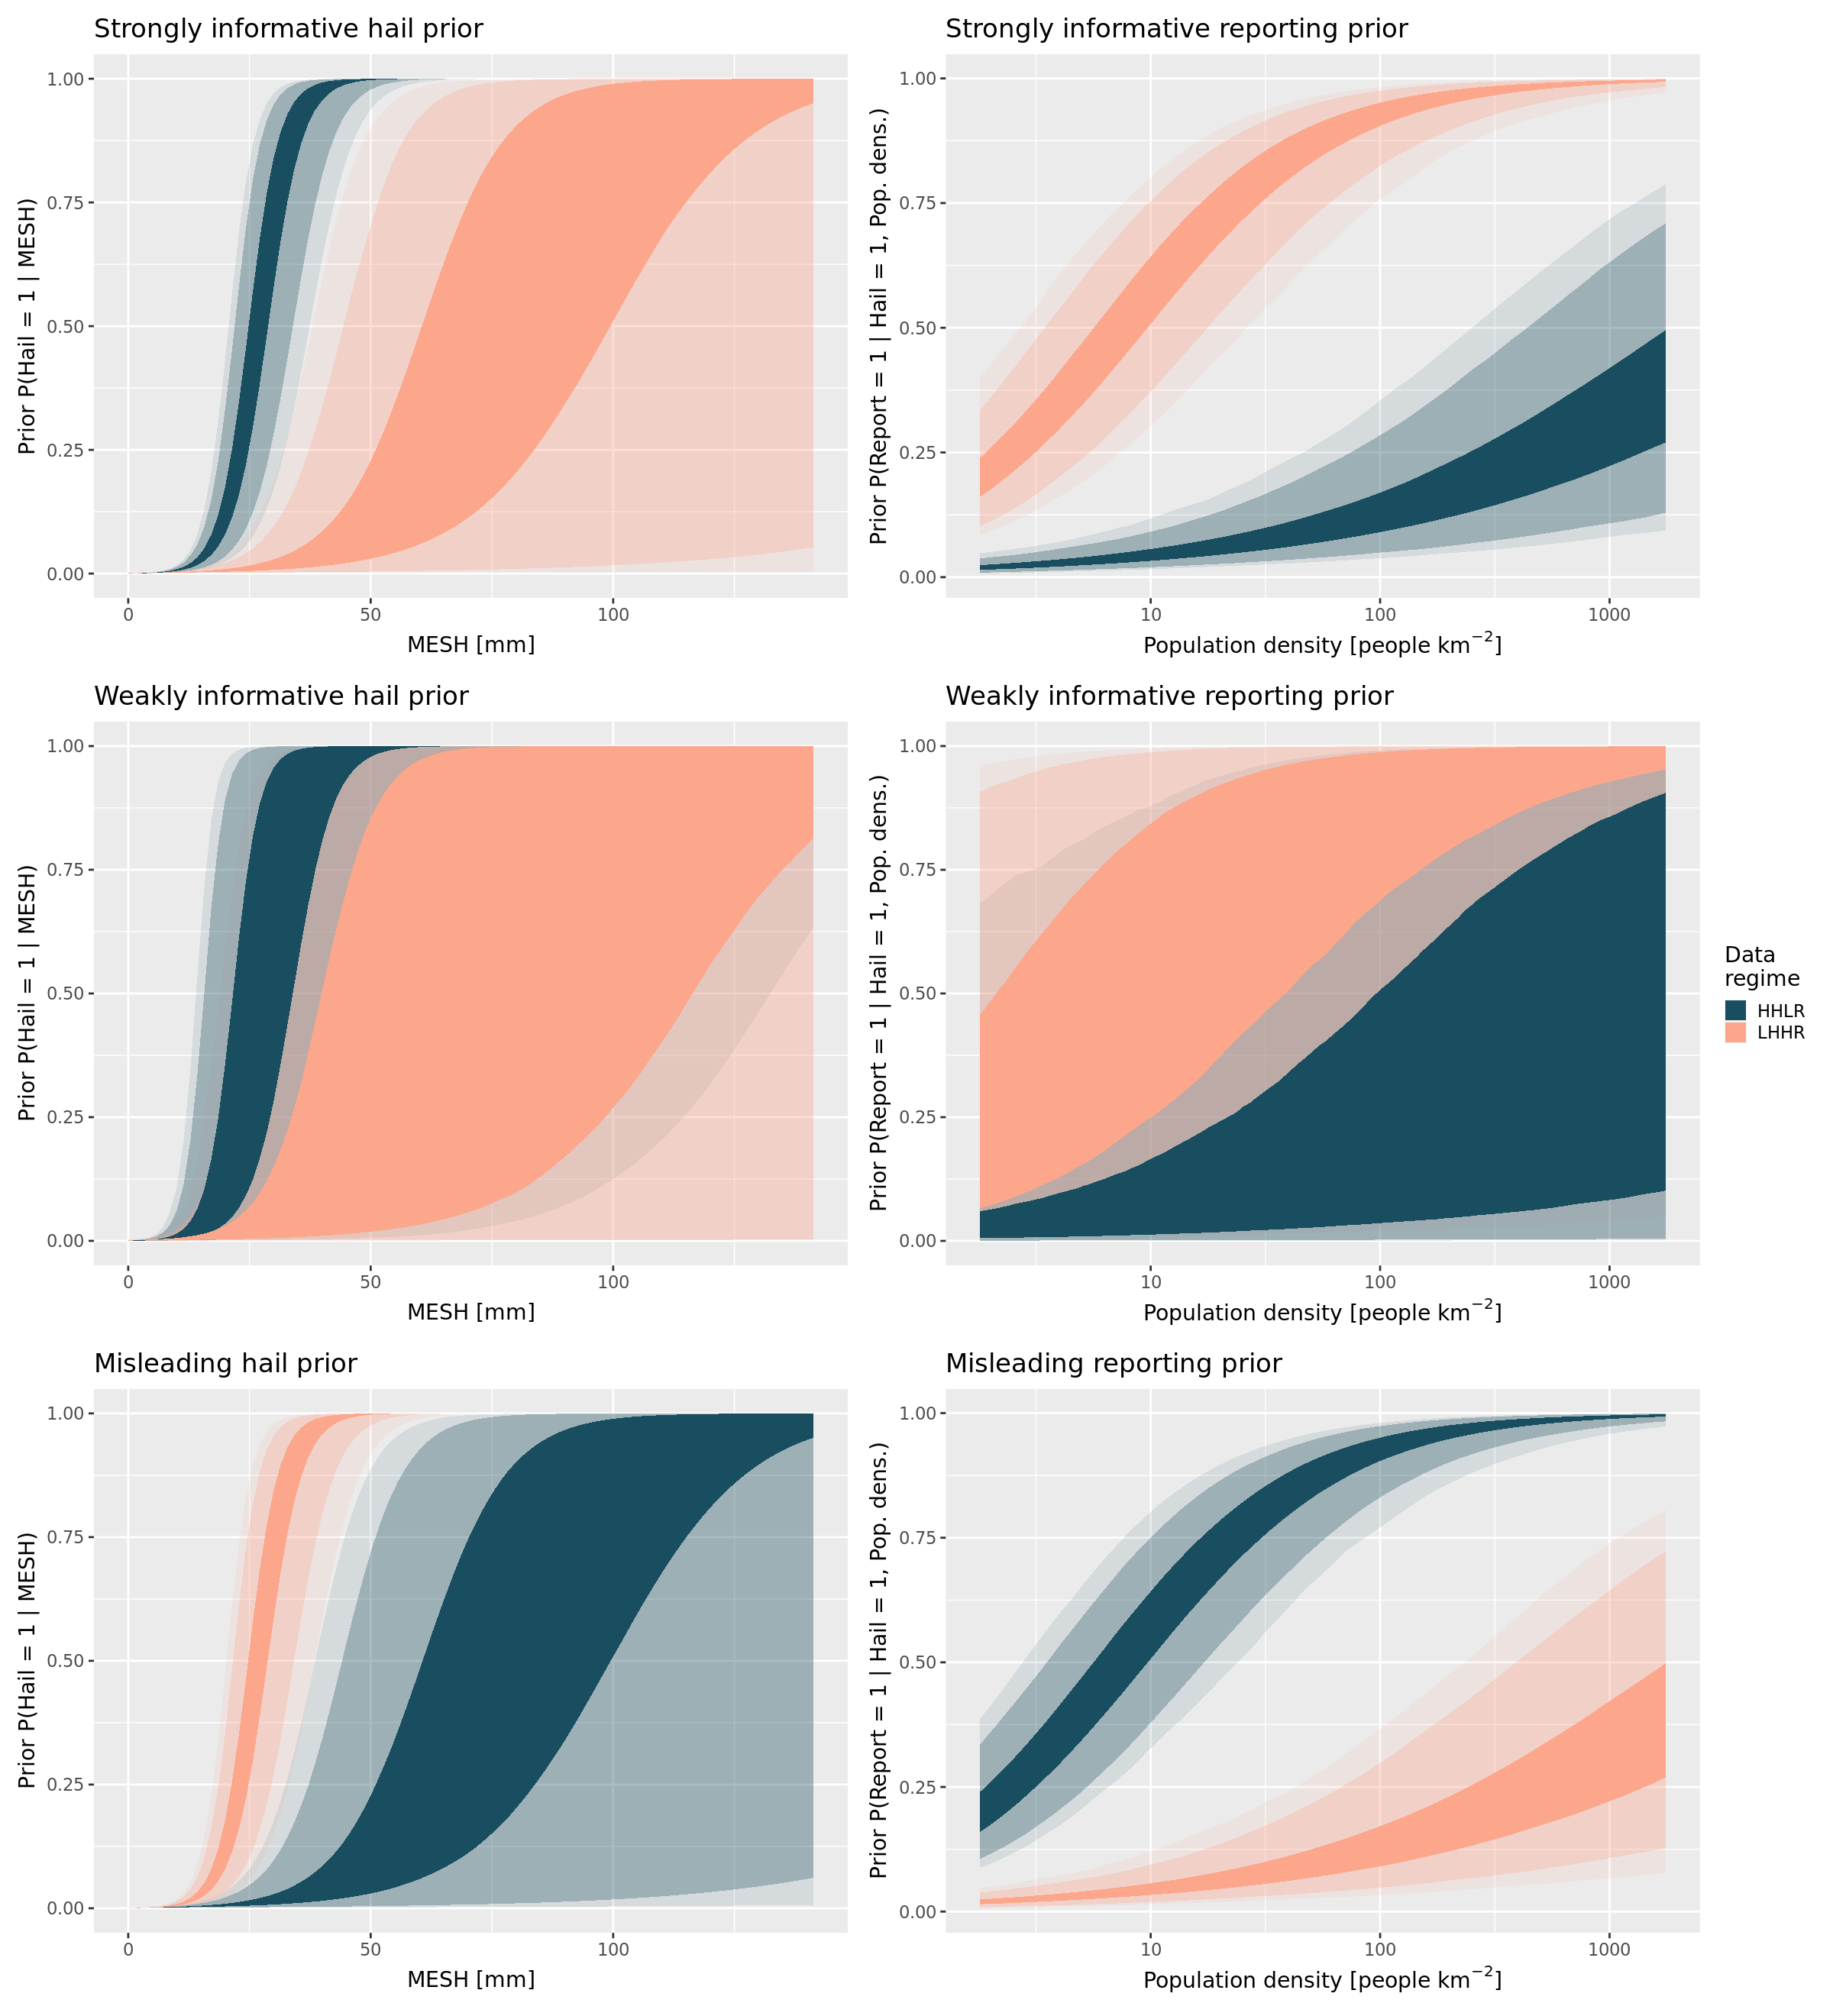

In [5]:
# plot size
options(repr.plot.width = 20, repr.plot.height = 22)

# iterating over all six combinations with nested map
map(c("hail", "report"), 
    \(x) map(c("strongly_informative", "weakly_informative", "misleading"), 
             \(y) generate_sim_prior_samples_and_plot(y, x))
   ) %>%
  # flatten into single (unnested) list
  flatten() %>%
  # wrap into grid
  wrap_plots(nrow = 3, byrow = FALSE) +
  plot_layout(guides = "collect")